## Importing Required Libraries

This cell imports the key libraries needed for distributed deep learning and image processing:

- `ray`: Enables scalable distributed computing for model training and data processing.
- `torch`: Core PyTorch package for building and training neural networks.
- `torchvision.models` and `torchvision.transforms`: Provides access to pretrained models (like ResNet152) and common image transformations.
- `PIL.Image`: Supports image loading and manipulation using the Pillow library.
- `numpy`: Essential package for efficient numerical operations and array manipulation.

In [1]:
import ray 
import torch 
from torchvision.models import resnet152, ResNet152_Weights
from torchvision import transforms
from PIL import Image
import numpy as np
import psutil

### Loading a Sample Image Batch from S3 with Ray Data

This cell demonstrates how to efficiently load image data from an S3 bucket using Ray Data:

- Reads images from an S3 URI in RGB mode into a Ray Dataset.
- Subsets the dataset to the first 1,000 images for quick experimentation.
- Retrieves a batch of 3 images as a dictionary of arrays.
- Converts the first image in the batch from a NumPy array to a PIL Image for display.

In [2]:
s3_uri = "s3://anonymous@air-example-data-2/imagenette2/train/"
ds = ray.data.read_images(s3_uri, mode="RGB")

2025-08-05 11:18:17,007	INFO worker.py:1747 -- Connecting to existing Ray cluster at address: 100.108.165.68:6379...
2025-08-05 11:18:17,018	INFO worker.py:1918 -- Connected to Ray cluster. View the dashboard at https://session-xsclvf1y3h8ri22vxrxzy7b516.i.anyscaleuserdata.com 
2025-08-05 11:18:17,020	INFO packaging.py:380 -- Pushing file package 'gcs://_ray_pkg_bbc96322b181b30d9732dd7396f21ba966c88dff.zip' (0.15MiB) to Ray cluster...
2025-08-05 11:18:17,022	INFO packaging.py:393 -- Successfully pushed file package 'gcs://_ray_pkg_bbc96322b181b30d9732dd7396f21ba966c88dff.zip'.


In [3]:
subset_ds = ds.limit(1000)

In [4]:
single_batch = subset_ds.take_batch(3)

2025-08-05 11:18:17,466	INFO logging.py:295 -- Registered dataset logger for dataset dataset_11_0
2025-08-05 11:18:17,487	INFO streaming_executor.py:117 -- Starting execution of Dataset dataset_11_0. Full logs are in /tmp/ray/session_2025-08-05_11-07-51_161730_2469/logs/ray-data
2025-08-05 11:18:17,488	INFO streaming_executor.py:118 -- Execution plan of Dataset dataset_11_0: InputDataBuffer[Input] -> TaskPoolMapOperator[ListFiles] -> TaskPoolMapOperator[ReadFiles] -> LimitOperator[limit=1000] -> LimitOperator[limit=3]


Running 0: 0.00 row [00:00, ? row/s]

- ListFiles 1: 0.00 row [00:00, ? row/s]

- ReadFiles 2: 0.00 row [00:00, ? row/s]

- limit=1000 3: 0.00 row [00:00, ? row/s]

- limit=3 4: 0.00 row [00:00, ? row/s]

2025-08-05 11:18:17,542	WARNING resource_manager.py:130 -- ⚠️  Ray's object store is configured to use only 27.8% of available memory (38.2GB out of 137.4GB total). For optimal Ray Data performance, we recommend setting the object store to at least 50% of available memory. You can do this by setting the 'object_store_memory' parameter when calling ray.init() or by setting the RAY_DEFAULT_OBJECT_STORE_MEMORY_PROPORTION environment variable.
2025-08-05 11:18:23,987	INFO streaming_executor.py:231 -- ✔️  Dataset dataset_11_0 execution finished in 6.50 seconds


In [5]:
single_batch.keys()

dict_keys(['image'])

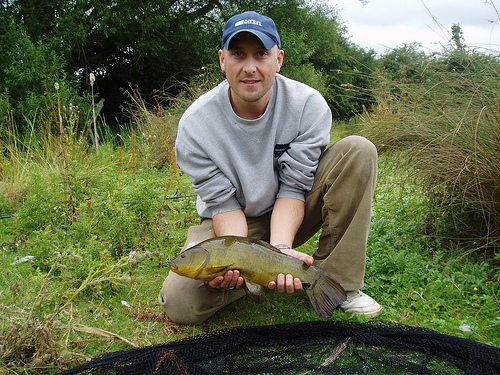

In [6]:
img = Image.fromarray(single_batch["image"][0])
img

### Applying Preprocessing Transforms to Images from Ray Dataset

This section defines and applies preprocessing steps to each image in the Ray Dataset:

- Loads the standard ImageNet normalisation and resizing transforms for ResNet-152.
- Combines the transforms with `ToTensor()` using `transforms.Compose`.
- Defines a `preprocess_image` function to:
  - Store the original image.
  - Apply the full transform pipeline, saving the result as `"transformed_image"`.
- Applies this function to every row in the dataset with `.map()`, creating a new dataset with both original and transformed images.
- Retrieves two samples as a batch and displays the available keys and the shape of the transformed images.

In [7]:
weights = ResNet152_Weights.IMAGENET1K_V1
imagenet_transforms = weights.transforms
transform = transforms.Compose([transforms.ToTensor(), imagenet_transforms()])

def preprocess_image(row: dict[str, np.ndarray]):
    return {
        "original_image": row["image"],
        "transformed_image": transform(row["image"]),
    }

In [8]:
transformed_ds = ds.map(preprocess_image)

In [9]:
two_batches = transformed_ds.take_batch(2)

2025-08-05 11:18:27,345	INFO logging.py:295 -- Registered dataset logger for dataset dataset_13_0
2025-08-05 11:18:27,352	INFO streaming_executor.py:117 -- Starting execution of Dataset dataset_13_0. Full logs are in /tmp/ray/session_2025-08-05_11-07-51_161730_2469/logs/ray-data
2025-08-05 11:18:27,353	INFO streaming_executor.py:118 -- Execution plan of Dataset dataset_13_0: InputDataBuffer[Input] -> TaskPoolMapOperator[ListFiles] -> TaskPoolMapOperator[ReadFiles] -> TaskPoolMapOperator[Map(preprocess_image)] -> LimitOperator[limit=2]


Running 0: 0.00 row [00:00, ? row/s]

- ListFiles 1: 0.00 row [00:00, ? row/s]

- ReadFiles 2: 0.00 row [00:00, ? row/s]

- Map(preprocess_image) 3: 0.00 row [00:00, ? row/s]

- limit=2 4: 0.00 row [00:00, ? row/s]

(Map(preprocess_image) pid=3976, ip=100.105.21.2) /tmp/ray/session_2025-08-05_11-07-51_161730_2469/runtime_resources/pip/95827506fa75379904c3ce3b9ca4084a17838508/virtualenv/lib/python3.12/site-packages/torchvision/transforms/functional.py:154: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /pytorch/torch/csrc/utils/tensor_numpy.cpp:203.)
(Map(preprocess_image) pid=3976, ip=100.105.21.2)   img = torch.from_numpy(pic.transpose((2, 0, 1))).contiguous()
2025-08-05 11:18:35,625	INFO streaming_executor.py:231 -- ✔️  Dataset dataset_13_0 execution finished in 8.27 seconds


In [10]:
print(f"Batch is a dictionary with the following keys : {two_batches.keys()}")

Batch is a dictionary with the following keys : dict_keys(['original_image', 'transformed_image'])


In [11]:
two_batches["transformed_image"].shape

(2, 3, 224, 224)

### Batch Inference Class for Distributed Prediction with ResNet-152

This class encapsulates batch inference logic for ResNet-152 using PyTorch and Ray Data:

- **Initialisation**:  
  - Loads ResNet-152 with pretrained ImageNet weights.
  - Sets the model to evaluation mode for inference.
- **Call Method**:  
  - Accepts a batch of preprocessed images (as NumPy arrays).
  - Converts the batch to a PyTorch tensor and moves it to the appropriate device.
  - Performs inference in no-grad mode for efficiency.
  - Returns both the predicted labels and the original images.

> **Note:**  
> When used with Ray Data’s `.map_batches()` or `.map()`, an instance of this class is automatically created on each Ray worker (CPU or GPU).  
> Ray Data manages distributed execution and device placement—you do **not** need to use `@ray.remote` on this class.

In [12]:
class BatchInferenceResNet:
    def __init__(self):
        self.weights = ResNet152_Weights.IMAGENET1K_V1
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model = resnet152(weights=self.weights).to(self.device)
        self.model.eval()

    def __call__(self, batch: dict[str, np.ndarray]):
        torch_batch = torch.from_numpy(batch["transformed_image"]).to(self.device)
        with torch.inference_mode():
            prediction = self.model(torch_batch)
            predicted_classes = prediction.argmax(dim=1).detach().cpu()
            predicted_labels = [
                self.weights.meta["categories"][i] for i in predicted_classes
            ]
            return {
                "predicted_label": predicted_labels,
                "original_image": batch["original_image"],
            }

In [13]:
predictions = transformed_ds.map_batches(
    BatchInferenceResNet,
    concurrency=1,  
    num_gpus=1,  
    batch_size=10,
)
prediction_batch = predictions.take_batch(5)

2025-08-05 11:18:38,402	INFO logging.py:295 -- Registered dataset logger for dataset dataset_15_0
2025-08-05 11:18:38,602	INFO streaming_executor.py:117 -- Starting execution of Dataset dataset_15_0. Full logs are in /tmp/ray/session_2025-08-05_11-07-51_161730_2469/logs/ray-data
2025-08-05 11:18:38,603	INFO streaming_executor.py:118 -- Execution plan of Dataset dataset_15_0: InputDataBuffer[Input] -> TaskPoolMapOperator[ListFiles] -> TaskPoolMapOperator[ReadFiles] -> TaskPoolMapOperator[Map(preprocess_image)] -> ActorPoolMapOperator[MapBatches(BatchInferenceResNet)] -> LimitOperator[limit=5]


Running 0: 0.00 row [00:00, ? row/s]

- ListFiles 1: 0.00 row [00:00, ? row/s]

- ReadFiles 2: 0.00 row [00:00, ? row/s]

- Map(preprocess_image) 3: 0.00 row [00:00, ? row/s]

- MapBatches(BatchInferenceResNet) 4: 0.00 row [00:00, ? row/s]

- limit=5 5: 0.00 row [00:00, ? row/s]

(Map(preprocess_image) pid=15693, ip=100.91.26.1) /tmp/ray/session_2025-08-05_11-07-51_161730_2469/runtime_resources/pip/95827506fa75379904c3ce3b9ca4084a17838508/virtualenv/lib/python3.12/site-packages/torchvision/transforms/functional.py:154: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /pytorch/torch/csrc/utils/tensor_numpy.cpp:203.)
(Map(preprocess_image) pid=15693, ip=100.91.26.1)   img = torch.from_numpy(pic.transpose((2, 0, 1))).contiguous()
(Map(preprocess_image) pid=3970, ip=100.105.21.2) /tmp/ray/session_2025-08-05_11-07-51_161730_2469/runtime_resources/pip/95827506fa75379904c3ce3b9ca4084a17838508/virtualenv/lib/python3.12/site-packages/torchvision/transfo

(_MapWorker pid=3279, ip=100.126.197.99) Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to /home/ray/.cache/torch/hub/checkpoints/resnet152-394f9c45.pth


  0%|          | 0.00/230M [00:00<?, ?B/s]99) 
 13%|█▎        | 29.0M/230M [00:00<00:01, 155MB/s]
 19%|█▉        | 43.9M/230M [00:00<00:01, 141MB/s]
 25%|██▍       | 57.5M/230M [00:00<00:01, 128MB/s]
 30%|███       | 69.9M/230M [00:00<00:02, 73.1MB/s]
 36%|███▌      | 82.5M/230M [00:00<00:01, 85.2MB/s]
 43%|████▎     | 98.2M/230M [00:00<00:01, 103MB/s] 
 48%|████▊     | 112M/230M [00:01<00:01, 112MB/s] 
 56%|█████▌    | 128M/230M [00:01<00:00, 128MB/s] 
 66%|██████▌   | 151M/230M [00:01<00:00, 159MB/s] 
 75%|███████▌  | 173M/230M [00:01<00:00, 178MB/s] 
 85%|████████▌ | 196M/230M [00:01<00:00, 196MB/s] 
100%|██████████| 230M/230M [00:01<00:00, 147MB/s] 
2025-08-05 11:19:09,474	INFO streaming_executor.py:231 -- ✔️  Dataset dataset_15_0 execution finished in 30.87 seconds


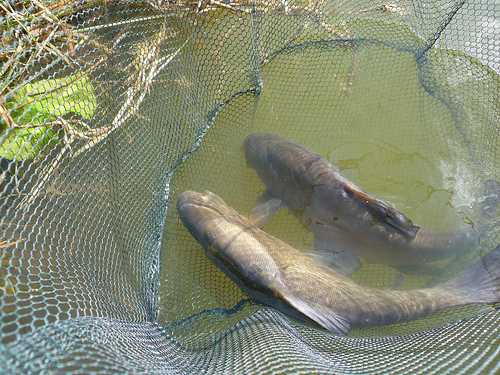

Label:  tench


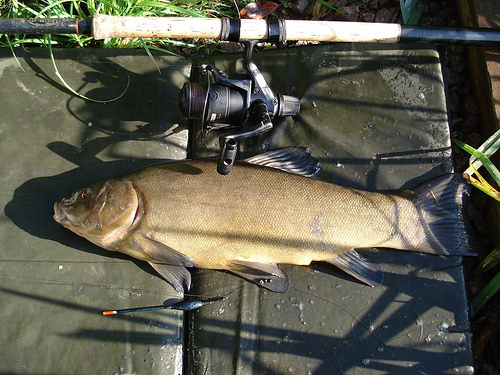

Label:  tench


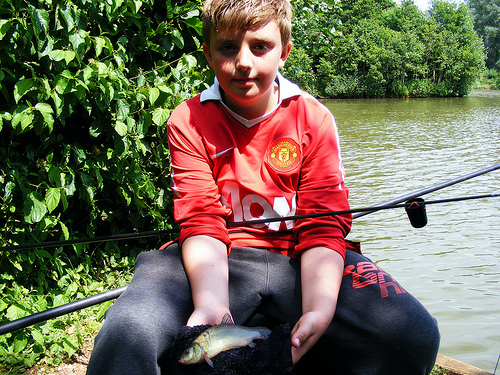

Label:  coho


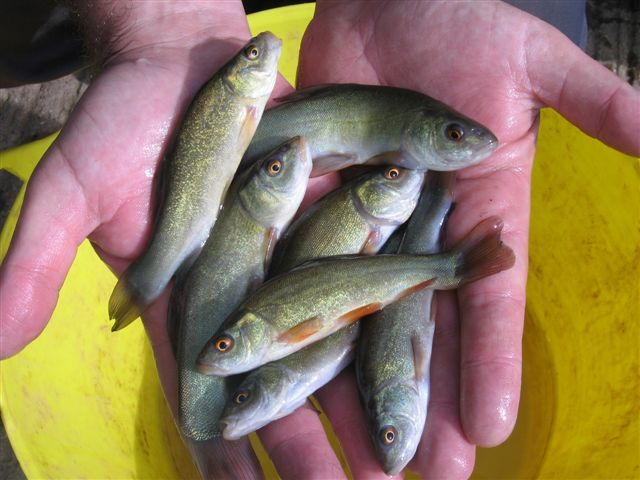

Label:  barracouta


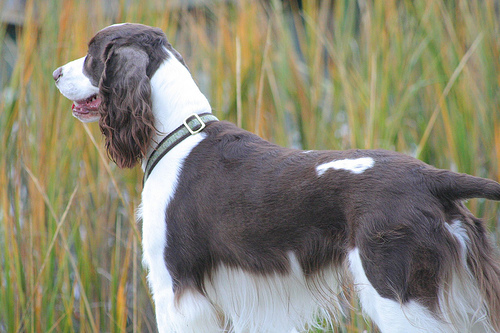

Label:  English springer


In [14]:
for image, prediction in zip(
    prediction_batch["original_image"], prediction_batch["predicted_label"]
):
    img = Image.fromarray(image)
    display(img)
    print("Label: ", prediction)